In [1]:
# !pip install tensorflow_probability


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import RobustScaler
os.sys.path.append('../../evaluation/')
import metrics


In [3]:
# training parameters
epochs = 30
batch_size = 16
n_dimensions = 2
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99)
input_path = '../../data/simulated_2d/'
output_path = './model/'
from predict_2d import extract_features


In [4]:
# load data
x_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
inputs_train = pickle.load(open(input_path+'/train/input_data.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/train/target_data.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/train/sizes.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/val/input_data.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/val/target_data.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/val/sizes.pkl', 'rb'))


In [5]:
dtype = tf.float32
y_train = tf.cast(np.array(y_train), dtype)
y_val = tf.cast(np.array(y_val), dtype)


In [6]:
# targets will be (means, std_devs, correlations)
# outputs will be (means, cholesky parameters)
# in loss function targets will be converted to means and covariances
# in loss function outputs will be converted to means and covariances


In [7]:
# nr = 8
# c = 0
# plt.figure(figsize=(3, 12), dpi=200)
# for i in range(0, nr*2, 2):
#     idx = np.random.choice(len(x_train))
#     plt.subplot(nr, 2, i+1)
#     plt.scatter(x_train[idx][:,0], x_train[idx][:,1], s=0.01, c='k', alpha=0.3)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlim([-4, 4])
#     plt.ylim([-4, 4])
#     plt.subplot(nr, 2, i+2)
#     plt.pcolormesh(extract_features(x_train[idx]).T)
#     plt.xticks([])
#     plt.yticks([])
# plt.tight_layout()


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train).squeeze()
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val).squeeze()


In [9]:
# # optionally add reference fraction prediction

# y_train = np.array(y_train)
# y_train = np.hstack([
#     y_train, 
#     np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
# ])

# y_val = np.array(y_val)
# y_val = np.hstack([
#     y_val, 
#     np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
# ])


In [10]:
# # standardize outputs
# scalery = RobustScaler()

# y_train = scalery.fit_transform(y_train)
# y_val = scalery.transform(y_val)


In [11]:
x_train = x_train[..., np.newaxis]
x_val = x_val[..., np.newaxis]


In [12]:
x_train.shape


(13000, 100, 100, 1)

In [13]:
y_train.shape


TensorShape([13000, 5])

In [14]:
# indices for correlation elements of a correlation matrix (upper triangular excluding diagonal)
correlation_indices = [(i, j) for i in range(n_dimensions) for j in range(i + 1, n_dimensions)]
correlation_indices = tf.constant(correlation_indices, dtype=tf.int64)

# function(s) to convert target batches to mean and covariance matrices
def target_to_stats(batch_vectors, n_dimensions=n_dimensions):
    """ Converts a batch of arrays each consisting of means, std devs, and pairwise correlations
        to separate arrays of mean vectors and covariance matrices
    """
    batch_size = tf.shape(batch_vectors)[0]
    # number of unique correlations in the upper triangular part
    num_correlations = (n_dimensions* (n_dimensions- 1)) // 2
    # extract statistics
    means = batch_vectors[:, :n_dimensions]
    std_devs = batch_vectors[:, n_dimensions:(n_dimensions*2)]
    correlations = batch_vectors[:, (n_dimensions*2):]
    correlations = tf.maximum(-1.0, tf.minimum(1.0, correlations))
    # expand indices for batch
    batch_indices = tf.reshape(tf.range(batch_size, dtype=tf.int64), (-1, 1, 1))
    batch_indices = tf.tile(batch_indices, (1, tf.shape(correlation_indices)[0], 1))
    expanded_indices = tf.concat([batch_indices, tf.tile(tf.expand_dims(correlation_indices, 0), (batch_size, 1, 1))], axis=-1)
    # scatter correlations into the upper triangular part
    upper_triangular = tf.scatter_nd(expanded_indices, correlations, shape=(batch_size, n_dimensions, n_dimensions))
    upper_triangular = upper_triangular + tf.transpose(upper_triangular, perm=[0, 2, 1]) - tf.linalg.diag(tf.linalg.diag_part(upper_triangular))
    correlation_matrix = tf.linalg.set_diag(upper_triangular, tf.ones((batch_size, n_dimensions), dtype=batch_vectors.dtype))
    # compute the covariance matrix
    std_devs = tf.expand_dims(std_devs, axis=-1)  # shape (batch_size, n_dimensions, 1)
    covariance_matrices = correlation_matrix * (std_devs @ tf.transpose(std_devs, perm=[0, 2, 1]))
    return means, covariance_matrices


In [15]:
print(target_to_stats(y_train)[0].shape)
print(target_to_stats(y_train)[1].shape)


(13000, 2)
(13000, 2, 2)


In [16]:
# create indices for upper triangular part of a matrix
indices = [(i, j) for i in range(n_dimensions) for j in range(i, n_dimensions)]
indices = tf.constant(indices, dtype=tf.int64)

# functions for processing target and output vectors in loss
def fill_triangular(batch_vector):
    batch_size = tf.shape(batch_vector)[0]
    # expand indices to include the batch dimension
    batch_indices = tf.reshape(tf.range(batch_size, dtype=tf.int64), (-1, 1, 1))
    batch_indices = tf.tile(batch_indices, (1, tf.shape(indices)[0], 1))
    expanded_indices = tf.concat([batch_indices, tf.tile(tf.expand_dims(indices, 0), (batch_size, 1, 1))], axis=-1)
    # scatter the batch vector elements into the upper triangular part of the matrices
    triangular = tf.scatter_nd(expanded_indices, batch_vector, shape=(batch_size, n_dimensions, n_dimensions))
    return triangular

def cholesky_to_covariance(cholesky_vectors):
    # scatter lower triangular values
    cholesky_matrix = fill_triangular(cholesky_vectors)
    # calculate the covariance matrix as L * L^T
    covariance_matrix = tf.matmul(cholesky_matrix, cholesky_matrix, transpose_b=True)
    return covariance_matrix


In [17]:
# loss functions
def kl_divergence(mean_true, cov_true, mean_pred, cov_pred):
    """ Computes KL divergence between two multivariate Gaussians
    """
    # Get dimensionality
    num_features = tf.cast(tf.shape(mean_pred)[-1], tf.float32)

    # Compute the inverse of cov_true
    inv_cov_true = tf.linalg.inv(cov_true)

    # Compute the trace term: trace(inv_cov_true @ cov_pred)
    trace_term = tf.linalg.trace(tf.linalg.matmul(inv_cov_true, cov_pred, transpose_a=False, transpose_b=True))

    # Compute the Mahalanobis term
    diff_mean = mean_true - mean_pred
    diff_mean_expanded = tf.expand_dims(diff_mean, axis=-1)
    mahalanobis_term = tf.reduce_sum(tf.linalg.matmul(inv_cov_true, diff_mean_expanded) * diff_mean_expanded, axis=-2)

    # Compute the log-determinants
    log_det_cov_pred = tf.linalg.logdet(cov_pred)
    log_det_cov_true = tf.linalg.logdet(cov_true)

    # KL divergence computation
    kl = 0.5 * (trace_term + tf.squeeze(mahalanobis_term) - num_features + log_det_cov_true - log_det_cov_pred)
    
    # Return the average KL divergence over the batch dimension
    return tf.reduce_mean(kl)

def kl_divergence_loss(y_true, y_pred):
    """ Wrapper for kl_divergence that formats target and output arrays
    """
    mean_true, cov_true = target_to_stats(y_true)
    mean_pred = y_pred[:,:n_dimensions]
    cov_pred = cholesky_to_covariance(y_pred[:,n_dimensions:])
    return kl_divergence(mean_true, cov_true, mean_pred, cov_pred)


In [18]:
# define model

cov_dim = n_dimensions * (n_dimensions + 1) // 2
if n_dimensions==2:
    ksize = 10
elif n_dimensions==3:
    ksize = 7

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv2D(32, kernel_size=ksize, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=ksize, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=ksize, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(y_train.shape[1], activation='tanh')(x)
model = tf.keras.models.Model(inputs, outputs)

# define loss and optimizer
model.compile(loss = kl_divergence_loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 45, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          409664

In [19]:
# plot model

# !pip install pydot
# !pip install graphviz

# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
# )


In [20]:
y_pred = model.predict(x_train)
y_pred.shape


407/407 [==============================] - 6s 2ms/step


(13000, 5)

In [21]:
y_pred.shape


(13000, 5)

In [22]:
mean_true, cov_true = target_to_stats(y_train)
mean_pred = y_pred[:,:n_dimensions]
cov_pred = cholesky_to_covariance(y_pred[:,n_dimensions:])


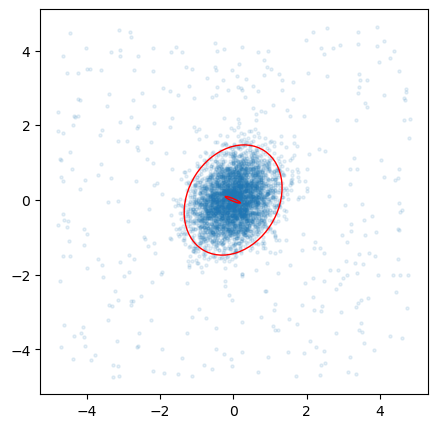

In [23]:
idx = np.random.choice(len(y_train))
plt.figure(figsize=(5,5))
plt.scatter(inputs_train[idx][:,0], inputs_train[idx][:,1], s=5, alpha=0.1);
plt.gca().add_patch(metrics.plot_cov_ellipse(mean_true[idx], cov_true[idx], color='r', fc='none'))
plt.gca().add_patch(metrics.plot_cov_ellipse(mean_pred[idx], cov_pred[idx], color='r', fc='none'))


In [24]:
kl_loss = kl_divergence_loss(y_train, y_pred)
kl_loss


<tf.Tensor: shape=(), dtype=float32, numpy=5.10793>

In [25]:
# def check_kl_nan(y_true, y_pred):
    
#     mean1 = y_pred[:, :matrix_size]
#     cov1 = cholesky_to_covariance(y_pred[:,matrix_size:])
#     mean2 = y_true[:, :matrix_size]
#     cov2 = flattened_to_triangular(y_true[:, matrix_size:])
#     cov2 = triangular_to_symmetric(cov2)
    
#     # Get dimensionality
#     num_features = tf.cast(tf.shape(mean1)[-1], tf.float32)
#     print('num_features: ', num_features)
    
#     # Compute the inverse of cov2
#     inv_cov2 = tf.linalg.inv(cov2)
#     print('inv_cov2: ',inv_cov2)
    
#     # Compute the trace term: trace(inv_cov2 @ cov1)
#     trace_term = tf.linalg.trace(tf.linalg.matmul(inv_cov2, cov1, transpose_a=False, transpose_b=True))
#     print('trace_term: ',trace_term)
    
#     # Compute the Mahalanobis term
#     diff_mean = mean2 - mean1
#     diff_mean_expanded = tf.expand_dims(diff_mean, axis=-1)
#     mahalanobis_term = tf.reduce_sum(tf.linalg.matmul(inv_cov2, diff_mean_expanded) * diff_mean_expanded, axis=-2)
#     print('mahalanobis_term: ',mahalanobis_term)
    
#     # Compute the log-determinants
#     log_det_cov1 = tf.linalg.logdet(cov1)
#     log_det_cov2 = tf.linalg.logdet(cov2)
#     print('log_det_cov1: ',log_det_cov1)
#     print('log_det_cov2: ',log_det_cov2)
#     print('\n')
    
# for i in np.where(np.isnan(kl_losses))[0]:
#     check_kl_nan(y_train[i:(i+1)], y_pred[i:(i+1)])


In [26]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/30


I0000 00:00:1722405292.310139    4026 service.cc:145] XLA service 0x7ff1ddf39340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722405292.310193    4026 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1722405292.342869    4026 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


813/813 [==============================] - ETA: 0s - loss: 0.4662
Epoch 1: val_loss improved from inf to 0.37688, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 15s 8ms/step - loss: 0.4662 - val_loss: 0.3769
Epoch 2/30
813/813 [==============================] - ETA: 0s - loss: 0.3772
Epoch 2: val_loss improved from 0.37688 to 0.37262, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 5s 6ms/step - loss: 0.3772 - val_loss: 0.3726
Epoch 3/30
812/813 [============================>.] - ETA: 0s - loss: 0.3773
Epoch 3: val_loss did not improve from 0.37262
813/813 [==============================] - 4s 5ms/step - loss: 0.3773 - val_loss: 0.3819
Epoch 4/30
813/813 [==============================] - ETA: 0s - loss: 0.3770
Epoch 4: val_loss did not improve from 0.37262
813/813 [==============================] - 4s 5ms/step - loss: 0.3770 - val_loss: 0.3791
Epoch 5/30
807/813 [============================>.] - ETA: 0s - loss: 0.3767
Epoch 5: val_loss did not improve from 0.37262
813/813 [==============================] - 4s 5ms/step - loss: 0.3766 - val_loss: 0.3770
Epoch 6/30
813/813 [==============================] - ETA: 0s - loss: 0.3764
Epoch 6: val_loss did not improve from 0.37262
813/813 [==============================] - 4s 5ms/step - loss: 0.3764 - val_loss: 0.3906
Epoch 7/30
804/813 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 5s 6ms/step - loss: 0.3790 - val_loss: 0.3723
Epoch 8/30
810/813 [============================>.] - ETA: 0s - loss: 0.3762
Epoch 8: val_loss did not improve from 0.37228
813/813 [==============================] - 4s 5ms/step - loss: 0.3762 - val_loss: 0.3763
Epoch 9/30
811/813 [============================>.] - ETA: 0s - loss: 0.3788
Epoch 9: val_loss did not improve from 0.37228
813/813 [==============================] - 4s 5ms/step - loss: 0.3787 - val_loss: 0.3761
Epoch 10/30
812/813 [============================>.] - ETA: 0s - loss: 0.3762
Epoch 10: val_loss did not improve from 0.37228
813/813 [==============================] - 4s 5ms/step - loss: 0.3761 - val_loss: 0.3859
Epoch 11/30
804/813 [============================>.] - ETA: 0s - loss: 0.3790
Epoch 11: val_loss improved from 0.37228 to 0.37135, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 5s 6ms/step - loss: 0.3786 - val_loss: 0.3714
Epoch 12/30
803/813 [============================>.] - ETA: 0s - loss: 0.3767
Epoch 12: val_loss did not improve from 0.37135
813/813 [==============================] - 4s 5ms/step - loss: 0.3759 - val_loss: 0.3719
Epoch 13/30
804/813 [============================>.] - ETA: 0s - loss: 0.3763
Epoch 13: val_loss did not improve from 0.37135
813/813 [==============================] - 4s 5ms/step - loss: 0.3764 - val_loss: 0.3718
Epoch 14/30
804/813 [============================>.] - ETA: 0s - loss: 0.3774
Epoch 14: val_loss did not improve from 0.37135
813/813 [==============================] - 4s 5ms/step - loss: 0.3775 - val_loss: 0.3820
Epoch 15/30
813/813 [==============================] - ETA: 0s - loss: 0.3761
Epoch 15: val_loss did not improve from 0.37135
813/813 [==============================] - 4s 5ms/step - loss: 0.3761 - val_loss: 0.3757
Epoch 16/30
804/813 [============================>.

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 5s 6ms/step - loss: 0.3768 - val_loss: 0.3712
Epoch 20/30
811/813 [============================>.] - ETA: 0s - loss: 0.3746
Epoch 20: val_loss improved from 0.37118 to 0.37050, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


813/813 [==============================] - 5s 6ms/step - loss: 0.3744 - val_loss: 0.3705
Epoch 21/30
804/813 [============================>.] - ETA: 0s - loss: 0.3750
Epoch 21: val_loss did not improve from 0.37050
813/813 [==============================] - 4s 5ms/step - loss: 0.3755 - val_loss: 0.3778
Epoch 22/30
804/813 [============================>.] - ETA: 0s - loss: 0.3769
Epoch 22: val_loss did not improve from 0.37050
813/813 [==============================] - 4s 5ms/step - loss: 0.3771 - val_loss: 0.3785
Epoch 23/30
804/813 [============================>.] - ETA: 0s - loss: 0.3754
Epoch 23: val_loss did not improve from 0.37050
813/813 [==============================] - 4s 5ms/step - loss: 0.3757 - val_loss: 0.3782
Epoch 24/30
803/813 [============================>.] - ETA: 0s - loss: 0.3764
Epoch 24: val_loss did not improve from 0.37050
813/813 [==============================] - 4s 5ms/step - loss: 0.3773 - val_loss: 0.3783
Epoch 25/30
813/813 [==============================

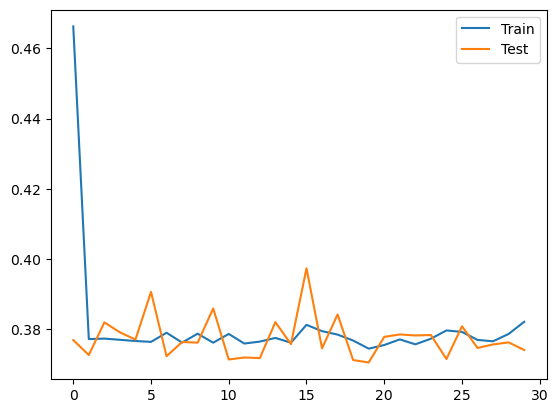

In [27]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend();
